In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks/MRI_data/Code

/content/drive/MyDrive/Colab_Notebooks/MRI_data/Code


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.7/480.7 KB 36.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [4]:
import numpy as np
import nibabel as nib
from aux_functions_time import *
from WarpPINN import WarpPINN
import time
import os

# Global Variables

In [5]:
volunteers = ["v1","v2","v4","v5","v6","v7","v8","v9","v10","v11","v12","v13","v14","v15","v16"]

# Images are cropped around the left ventricle since we are interested in this region.
crop_list = [[90, 190, 70, 170], [80, 170, 85, 175], [95, 185, 65, 155], [90, 180, 80, 170],
            [70, 160, 80, 170], [100, 200, 100, 200], [130, 220, 80, 170], [60, 160, 100, 190],
            [80, 160, 50, 140], [100, 200, 70, 170], [70, 160, 100, 190], [80, 170, 80, 170],
            [80, 170, 60, 150], [50, 140, 90, 180], [60, 150, 60, 150]] 

# Images need to be flipped
flip_list = [ [], [], [2], [2,3], [2,3], [2,3], [2], [], [2,3], [2,3], [3], [2,3], [2,3], [2,3], [2,3]]

# Choose volunteer
idx_vol = 0
volunteer = volunteers[idx_vol]

# Loading a bunch of data

In [6]:
data_path = os.path.join( 'data', volunteer) # For cluster

# Image
imt_path = os.path.join(data_path,'imt.nii.gz')

if os.path.exists(imt_path):
    imt_data = nib.load( imt_path )
else:
    imt_data = create_stack(data_path)

header = imt_data.header
pix_dim = header['pixdim']

# Pixel spacing of image
pixsp_x = pix_dim[1]
pixsp_y = pix_dim[2]
pixsp_z = pix_dim[3]

# Crop
crop_x_in = crop_list[idx_vol][0]
crop_x_end = crop_list[idx_vol][1]
crop_y_in = crop_list[idx_vol][2]
crop_y_end = crop_list[idx_vol][3]

crop_str = str(crop_x_in)+'_'+str(crop_x_end)+'_'+str(crop_y_in)+'_'+str(crop_y_end)

# Getting all the images
# Dimension of the stack: [time x slice x X x Y]
imt = imt_data.get_fdata()
imt = np.transpose(imt, [3, 2, 1, 0])

imt = np.flip(imt, flip_list[idx_vol]) 
imt = imt[:, :, crop_y_in:crop_y_end, crop_x_in:crop_x_end].astype(np.float32)

# Reference image is the first time in the stack
imr = imt[0, :, :, :]

frames = imt.shape[0]
slices = imt.shape[1]

# Mesh coords of image voxels and segmentation nodes
im_mesh, segm_mesh = im_and_segm_mesh_hernan(crop_x_in, crop_x_end, crop_y_in, crop_y_end, data_path)

# Mesh coords for background nodes
bg_mesh_file = os.path.join(data_path, 'background_points_'+crop_str+'.npy')
bg_mesh = background_mesh(data_path, imt_data, crop_x_in, crop_x_end, crop_y_in, crop_y_end, bg_mesh_file, slices)

# Boolean mask: 1 if the voxel is in the LV, 0 otherwise
bool_mask_file = os.path.join(data_path, 'boolean_mask_'+crop_str+'.npy')
bool_mask = boolean_mask(data_path, imt_data, crop_x_in, crop_x_end, crop_y_in, crop_y_end, bool_mask_file )

### Neural Network ###

# Layers for u1, u2 and u3
neu = 2**6
layers_u = [4, neu, neu, neu, neu, neu, 3]

reg_mask = 1
lmbmu = 10**5
mu_NeoHook = 1e-5

# Number of iterations desired for the registration from t_1 to t_i
It = 300000
batch_size = 1000
# Number of points in LV used to calculate the Neo Hookean by minibatch
N_nodes = len(segm_mesh)
# Number of epochs 
nEpoch = int( np.ceil(It * batch_size / N_nodes) )

pix_crop = [pixsp_x, pixsp_y, pixsp_z, crop_x_in, crop_y_in]

model = WarpPINN(imr, imt, layers_u, bool_mask, im_mesh, segm_mesh, bg_mesh, lmbmu, pix_crop, reg_mask = reg_mask)


Device mapping: no known devices.


# Pretrain model

Once initialised, the network is first pre-trained to get $u_{\theta}(x)\sim 0$, then the deformation field approximates the identity  $\varphi(X) = X + u_{\theta}(X) \sim X$

In [7]:
t0 = time.time()
tol_pretrain = 1e-6
model.pretrain(tol_pretrain)
t1 = time.time()

It: 0, Loss: 1.305e-01, Time: 3.62
It: 1, Loss: 4.955e-02, Time: 2.29
It: 2, Loss: 1.421e-02, Time: 1.74
It: 3, Loss: 8.741e-03, Time: 0.82
It: 4, Loss: 1.912e-02, Time: 0.83
It: 5, Loss: 3.289e-02, Time: 0.85
It: 6, Loss: 4.136e-02, Time: 0.84
It: 7, Loss: 4.192e-02, Time: 0.84
It: 8, Loss: 3.638e-02, Time: 0.82
It: 9, Loss: 2.770e-02, Time: 0.83
It: 10, Loss: 1.864e-02, Time: 0.83
It: 11, Loss: 1.081e-02, Time: 0.84
It: 12, Loss: 5.197e-03, Time: 1.16
It: 13, Loss: 2.028e-03, Time: 1.52
It: 14, Loss: 1.074e-03, Time: 1.55
It: 15, Loss: 1.751e-03, Time: 1.46
It: 16, Loss: 3.328e-03, Time: 1.41
It: 17, Loss: 5.122e-03, Time: 0.92
It: 18, Loss: 6.663e-03, Time: 0.82
It: 19, Loss: 7.685e-03, Time: 0.84
It: 20, Loss: 8.080e-03, Time: 0.84
It: 21, Loss: 7.834e-03, Time: 0.84
It: 22, Loss: 6.994e-03, Time: 0.82
It: 23, Loss: 5.747e-03, Time: 0.82
It: 24, Loss: 4.317e-03, Time: 0.82
It: 25, Loss: 2.974e-03, Time: 0.82
It: 26, Loss: 1.889e-03, Time: 0.84
It: 27, Loss: 1.128e-03, Time: 0.83
It

KeyboardInterrupt: ignored

# Train model

Epoch: 0, It: 0, Loss: 2.355e-02, Loss L1: 1.987e-02, Loss NeoHook: 3.680e+02, Time: 7.16
Epoch: 0, It: 100, Loss: 2.773e-02, Loss L1: 2.767e-02, Loss NeoHook: 5.936e+00, Time: 68.98
Reference image vs predicted image frame 0
Image | MSE: 3.12467e-01, SSIM: 0.91723
Reference image vs Template image frame 0
Image | MSE: 0.00000e+00, SSIM: 1.00000
Reference image vs predicted image frame 1
Image | MSE: 3.22955e-01, SSIM: 0.90723
Reference image vs Template image frame 1
Image | MSE: 1.21262e-01, SSIM: 0.98309
Reference image vs predicted image frame 2
Image | MSE: 3.42533e-01, SSIM: 0.89210
Reference image vs Template image frame 2
Image | MSE: 2.13433e-01, SSIM: 0.95024
Reference image vs predicted image frame 3
Image | MSE: 3.67218e-01, SSIM: 0.87599
Reference image vs Template image frame 3
Image | MSE: 2.82560e-01, SSIM: 0.91597
Reference image vs predicted image frame 4
Image | MSE: 3.97785e-01, SSIM: 0.85223
Reference image vs Template image frame 4
Image | MSE: 3.47478e-01, SSIM: 

/usr/local/lib/python3.9/dist-packages/pyvista/core/dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(


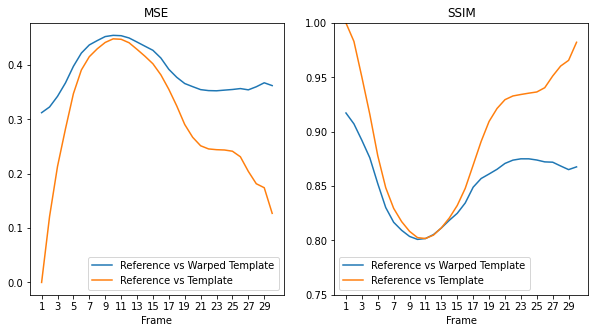

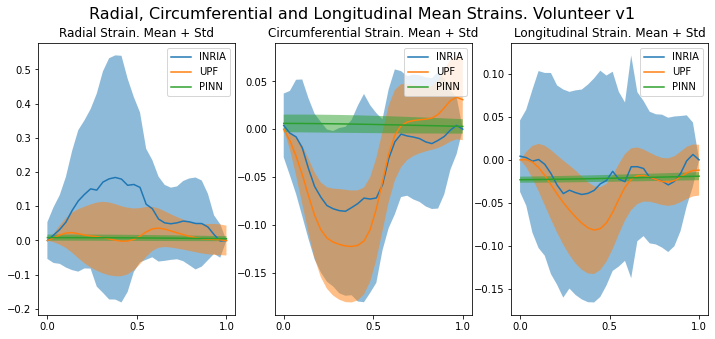

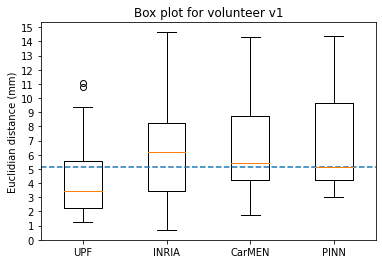

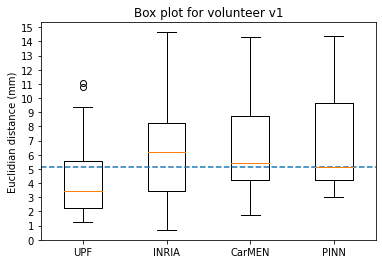

In [8]:
# An exception may occur during backpropagation if J = 0 at some point.

try:
    # Choose either L1 norm or L2 norm to measure the difference between reference and warped template images

    model.train_Adam_L1_NeoHook(nEpoch, mu_NeoHook, size=batch_size)
    #model.train_Adam_MSE_NeoHook(nEpoch, mu_NeoHook, size=batch_size) 

except:
    
    print('J = 0 at some point. Training has stopped. Predictions are made from last iteration.')

finally:

    ### Save model ###

    str_neu = str(neu)
    str_mask = str(reg_mask)
    str_batch = str(batch_size)

    str_mu_NeoHook = str(mu_NeoHook)
    str_lmbmu = str(lmbmu)

    model_name = 'model_L1_'+str_mu_NeoHook+'_NH_lmbmu_'+str_lmbmu+'_mask_'+str_mask+'_neu_'+str_neu+'_batch_'+str_batch
    # model_name = 'model_L2_'+str_mu_NeoHook+'_NH_lmbmu_'+str_lmbmu+'_mask_'+str_mask+'_neu_'+str_neu+'_batch_'+str_batch

    model_dir = os.path.join( 'results', 'L1', volunteer, model_name) 
    #model_dir = os.path.join( 'results', 'L2', volunteer, model_name) 

    model_save = os.path.join(model_dir, model_name)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model.saver.save(model.sess, model_save)

    t2 = time.time()    

    ### Loading data for post-processing ###

    # Mesh coords of nodes in the ventricle to be deformed to simulate heart beating
    surf_mesh = meshio.read( os.path.join( data_path, volunteer+'_surf_vol.vtk' ))

    # Ground truth landmarks. Get landmarks at first frame from observer 1 (in the first frame they are the same for observer 2)
    gt_inria_lmks_path = os.path.join(data_path, 'LMKS_GT/INRIA_COORDINATES')
    gt_obs1 = os.path.join(gt_inria_lmks_path, 'obs1_groundTruth00.vtk')
    lmks_gt_obs1 = read_lmks_mesh(gt_obs1)

    # For strains

    # Mesh coords
    origin = np.mean(surf_mesh.points, axis = 0)
    cart_coords = surf_mesh.points - origin
    angle = np.arctan2(cart_coords[:,1], cart_coords[:,0])

    rho = np.hstack((np.cos(angle)[:,None], np.sin(angle)[:,None]))
    theta = np.hstack((-np.sin(angle)[:,None], np.cos(angle)[:,None]))

    rho_1 = np.reshape(rho, [-1,1,2])
    rho_2 = np.reshape(rho, [-1,2,1])

    theta_1 = np.reshape(theta, [-1,1,2])
    theta_2 = np.reshape(theta, [-1,2,1])

    # Surface at first frame
    surf_path = os.path.join(model_dir, 'surfaces')
    if not os.path.exists(surf_path):
        os.makedirs( surf_path )

    num_nodes = len(surf_mesh.points)

    file_name = os.path.join(surf_path, 'v0_surf.vtk')
    meshio.write(file_name, meshio.Mesh(points=surf_mesh.points, cells={'triangle': surf_mesh.cells_dict['triangle'], 'tetra': surf_mesh.cells_dict['tetra']}, \
                    point_data = {'radStrain':np.zeros([num_nodes]), 'circStrain':np.zeros([num_nodes]), 'longStrain': np.zeros([num_nodes]), 'Jacobian': np.ones([num_nodes])}))

    # Landmarks at first frame
    lmks_path = os.path.join(model_dir, 'lmks')
    if not os.path.exists( lmks_path ):
        os.makedirs( lmks_path )

    file_name = os.path.join( lmks_path, 'lmks_results{0}.vtk'.format(0))
    meshio.write(file_name, meshio.Mesh(points=lmks_gt_obs1, cells={}))

    # To generate some basic plots for Reference image vs Predicted image
    mse_pred_list = []
    ssim_pred_list = []

    # To generate some basic plots for Reference image vs Template image
    mse_temp_list = []
    ssim_temp_list = []

    # To generate some basic plots for strains
    # Radial
    mean_rr = np.zeros([frames])
    median_rr = np.zeros([frames])
    std_rr = np.zeros([frames])
    # Circumferential
    mean_cc = np.zeros([frames])
    median_cc = np.zeros([frames])
    std_cc = np.zeros([frames])
    # Longitudinal
    mean_ll = np.zeros([frames])
    median_ll = np.zeros([frames])
    std_ll = np.zeros([frames])

    # Warping at different times

    for i in range(frames):

        # Surface warp
        surf_mesh_warp, u1, u2, u3, u1x, u1y, u1z, u2x, u2y, u2z, u3x, u3y, u3z, J = model.surface_deformation(surf_mesh.points, i)

        grad_um = np.hstack((u1x, u1y, u1z, u2x, u2y, u2z, u3x, u3y, u3z))
        grad_um = np.reshape(grad_um, [-1, 3, 3])
        grad_um_t = np.transpose(grad_um, [0, 2, 1])

        Em = 1/2 * (grad_um + grad_um_t + np.matmul(grad_um_t, grad_um))

        Em_new = Em[:,0:2,0:2]
        # Radial strain
        Em_rr = np.matmul(rho_1, np.matmul(Em_new, rho_2))
        # Circumferential strain
        Em_cc = np.matmul(theta_1, np.matmul(Em_new, theta_2))
        # Longitudinal strain
        Em_ll = Em[:,2,2]

        mean_rr[i] = np.mean(Em_rr)
        median_rr[i] = np.median(Em_rr)
        std_rr[i] = np.std(Em_rr)

        mean_cc[i] = np.mean(Em_cc)
        median_cc[i] = np.median(Em_cc)
        std_cc[i] = np.std(Em_cc)

        mean_ll[i] = np.mean(Em_ll)
        median_ll[i] = np.median(Em_ll)
        std_ll[i] = np.std(Em_ll)

        # Save warped surface with strains and jacobian
        file_name = os.path.join(surf_path, 'v{0}_surf.vtk'.format(i+1))
        meshio.write(file_name, meshio.Mesh(points=surf_mesh_warp, cells={'triangle': surf_mesh.cells_dict['triangle']}, \
                    point_data = {'radStrain':Em_rr, 'circStrain':Em_cc, 'longStrain':Em_ll, 'Jacobian': J}))

        # Save warped Landmarks 
        lmks_warp_obs1_mesh = model.lmks_deformation(lmks_gt_obs1, i)
        file_name = os.path.join(lmks_path, 'lmks_results{0}.vtk'.format(i+1))
        meshio.write(file_name, meshio.Mesh(points=lmks_warp_obs1_mesh, cells={}))

        # Prediction on voxel coordinates

        imr_pred, u1_pred, u2_pred, u3_pred, u1x_pred, u1y_pred, u1z_pred, u2x_pred, u2y_pred, u2z_pred, u3x_pred, u3y_pred, u3z_pred, J_pred = model.predict(i)

        imt_i = imt[i,:,:,:]
        ub_im = np.max([np.max(imr), np.max(imt)])
        lb_im = np.min([np.min(imr), np.min(imt)])
        imr_resc = (imr - lb_im) / (ub_im - lb_im)
        imt_resc = (imt_i - lb_im) / (ub_im - lb_im)

        # Comparing predicted image and reference image
        print('Reference image vs predicted image frame {0}'.format(i))
        compare_images(imr_resc[1:-1], imr_pred[1:-1])
        print('Reference image vs Template image frame {0}'.format(i))
        compare_images(imr_resc[1:-1], imt_resc[1:-1])

        mse_pred_list.append( np.sqrt((np.square(imr_resc[1:-1]-imr_pred[1:-1])).mean() / (np.square(imr_resc[1:-1])).mean()) )
        mse_temp_list.append( np.sqrt((np.square(imr_resc[1:-1]-imt_resc[1:-1])).mean() / (np.square(imr_resc[1:-1])).mean()) )
        ssim_pred_list.append( ssim(imr_resc[1:-1], imr_pred[1:-1]) )
        ssim_temp_list.append( ssim(imr_resc[1:-1], imt_resc[1:-1]) )

    np.save( os.path.join(model_dir, 'mse_pred_list.npy'), np.array(mse_pred_list))
    np.save( os.path.join(model_dir, 'ssim_pred_list.npy'), np.array(ssim_pred_list))
    np.save( os.path.join(model_dir, 'mse_temp_list.npy'), np.array(mse_temp_list))
    np.save( os.path.join(model_dir, 'ssim_temp_list.npy'), np.array(ssim_temp_list))

    np.save( os.path.join(model_dir, 'loss_registration.npy'), np.array(model.lossit_MSE))
    np.save( os.path.join(model_dir, 'loss_nh.npy'), np.array(model.lossit_NeoHook))
    np.save( os.path.join(model_dir, 'loss.npy'), np.array(model.lossit_value))

    # Generate plots of MSE and SSIM
    mse_ssim(model_dir, frames, mse_pred_list, mse_temp_list, ssim_pred_list, ssim_temp_list)

    # Generate strain graphs
    pinn_strains = np.vstack([mean_rr, median_rr, std_rr, mean_cc, median_cc, std_cc, mean_ll, median_ll, std_ll ])
    global_strain(data_path, model_dir, frames, pinn_strains)

    box_plots(data_path, model_dir)
